# HW3 - Exploration strategies



In this homework, you will implement and compare a number of exploration strategies.
___

- [ ] Plot rewards/epoch


In [1]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import random
from collections import deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pprint

n_epochs = 6000  # Number of epochs


# Utils =============

def smooth(x,window_len=11,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

class mean_val:
    def __init__(self):
        self.k = 0
        self.val = 0
        self.mean = 0

    def append(self,x):
        self.k += 1
        self.val += x
        self.mean = self.val/self.k

    def get(self):
        return self.mean


class logger0:
    def __init__(self):
        self.log = dict()

    def add_log(self,name):
        self.log[name] = []

    def add_item(self,name,x):
        self.log[name].append(x)

    def get_log(self,name):
        return self.log[name]

    def get_keys(self):
        return self.log.keys()

    def get_current(self,name):
        return self.log[name][-1]

class logger:
    def __init__(self, names= [], nseries =1):
        self.nseries = nseries
        self.log = dict()
        if len(names)>0:
          for n in names:
            self.add_log(n)

    def add_log(self,name):
        s = []
        for _ in range(self.nseries):
            s.append([])
        self.log[name] = s

    def add_item(self, name, x, s = 0):
        self.log[name][s].append(x)

    def get_log(self,name):
        s = self.log[name] if self.nseries>1 else self.log[name][0]
        return s

    def get_keys(self):
        return self.log.keys()

    def get_current(self,name,s=0):
        return self.log[name][s][-1]


# display
def disp(logger, title, logname, figsize=(20, 16), fontsize = 20):
    plt.Figure(figsize)

    Y = np.asarray(logger.get_log(logname))
    Y2 = smooth(Y)
    x = np.linspace(0, len(Y), len(Y))
    fig1 = plt.figure()
    ax1 = plt.axes()
    ax1.plot(x, Y, Y2)

    plt.xlabel("Training steps", fontsize=fontsize)
    plt.ylabel("Reward", fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig("hw3_"+title+".png", dpi=300)

def disp1(Y, title, logname, figsize=(20, 16), fontsize = 20):
    plt.Figure(figsize)
    Y2 = smooth(Y)
    x = np.linspace(0, len(Y), len(Y))
    fig1 = plt.figure()
    ax1 = plt.axes()
    ax1.plot(x, Y, Y2)

    plt.xlabel("Training steps", fontsize=fontsize)
    plt.ylabel("Reward", fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig("hw3_"+title+".png", dpi=300)


## Problem 1 (2 points)

Implement a **combination lock MDP** of length H = 20, number of actions A = 10, number of states per step = 3. Denote the states as $\{s_{h;1}, s_{h;2}, s_{h;3}\}_{h=1:20}$. While initializing the MDP, uniformly randomly choose one out of ten actions for each stage as the **good action**, denoted as $\{a^*_h\}_{h=1:20}$. Define the transition as:

$$P(s_{h+1;1}|s_{h;1},a^*_h)=P(s_{h+1;2}|s_{h;1},a^*_h)=P(s_{h+1;1}|s_{h;2},a^*_h)=P(s_{h+1;2}|s_{h;2},a^*_h)=0.5$$
while for $a\neq a^*_h$,
$$P(s_{h+1;3}|s_{h;1},a)=P(s_{h+1;3}|s_{h;2},a)=P(s_{h+1;3}|s_{h;3},a)=1$$
Lastly, if you are in the bad state, for any action $a$,
$$P(s_{h+1;3}|s_{h;3},a)=1$$
In terms of rewards, the agent receives a reward of 10 upon reaching $s_{H,1}$ or $s_{H,2}$, at which point the episode will also reset. Otherwise the reward will always be 0. Therefore, this environments consist of H levels with 3 states per level and 10 actions. Two of the states lead to high reward and the third is a dead state from which it is impossible to recover.

In [2]:
class CombLockMDP(gym.Env):
    """
    Methods:
        reset(): Resets the environment to the starting state.
        step(action): Takes a step in the environment.
    """
    def __init__(self, H=20, A=10, S=3, R=10, seed=0):
        self.H = H
        self.A = A
        self.S = S
        self.R = R
        self.seed = seed
        self.action_space = A
        self.observation_space = 2
        self.h_exit = -1 # Position where "dead" state or end is reached

        # Set random seed
        self.rng = np.random.RandomState(seed)  # Random number generator for good actions

        # Initialize good actions randomly
        self.good_actions = self.rng.choice(self.A, size=self.H, replace=True)
        # Initialize state
        self.state = (0,0)  # Start at first dial (=0), good state (s1=1)
        states = [(h,s) for h in range(H) for s in range(S)]
        D_states = {v:k for k,v in enumerate(states)}
        self.index = D_states
        self.keys = {v: k for k, v in D_states.items()}

    def reset(self):
        # Reset state to the starting state
        s = int(np.random.rand()<.5)
        self.state = (0,s)  # Start at first dial (=0), good state (s1=1)
        return np.array(self.state)

    def step(self, action):
        # Unpack current state
        h, s = self.state

        # Calculate new position
        if h < self.H - 1:
            # State
            if s != self.S-1: # good state
                if action == self.good_actions[h]: # > good state
                    s = int(np.random.rand()<.5)
                else: # > dead state
                    s = self.S-1
                    self.h_exit = h
            # Step
            h += 1
            self.state = (h,s)

        # Output values
        done = False
        reward = 0
        if h == self.H-1 : # Last step
            done = True
            reward = 0 if s == self.S-1 else self.R
            if self.h_exit == -1:
                self.h_exit = h

        return np.array(self.state), reward, done, self.h_exit


    def reward(self, state):
        # Unpack current state
        h, s = state
        reward = self.R if (h == self.H-1 and s < self.S-1) else 0
        return reward

    def render(self, mode='human', close=False):
        grid = np.zeros((self.H, self.S), dtype=str)
        # Represent the agent and treasure
        h,s = self.state
        grid[h,s] = 'O' if s<self.S-1 else 'X'
        steps = [t%10 for t in range(self.H)]
        print(' ',steps)
        print(grid.T)



def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
    cumsum = np.zeros_like(x)
    cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        cumsum[t] = x[t] + gamma * cumsum[t + 1]
    return cumsum

These environments consist of H levels with 3 states per level and 10
 actions. Two of the states lead to high reward and the third is a dead state from which it is impossible to recover.
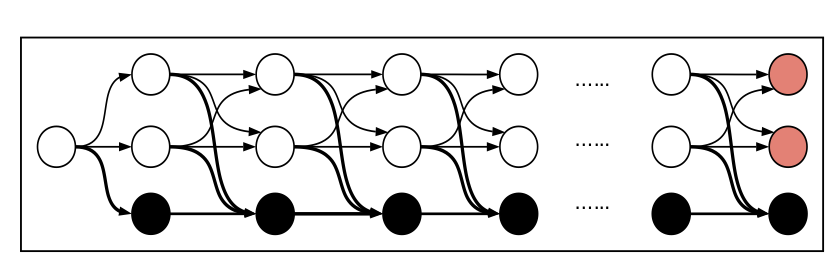

This part of code tests the 'CombLockMDP' environment.


In [3]:

# Create and use the 'CombLockMDP' environment
env = CombLockMDP(H = 20, A = 10)

state = env.reset()
print(state)
# print(env.good_actions) # [5 0 3 3 7 9 3 5 2 4 7 6 8 8 1 6 7 7 8 1]

actions = [5, 0, 3, 3, 7, 9, 3, 5, 2,  3,  4, 7, 6, 8, 8, 1, 6, 7, 7, 8, 1]
for a in actions:
  env.render()
  next_state, reward, done, info = env.step(a)
  print(a, '>', next_state, reward, done, info )
  print()

  if done:
    break
print('>>>')
env.render()
print(len(actions))


[0 0]
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[['O' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]
5 > [1 1] 0 False -1

  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' 'O' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]
0 > [2 0] 0 False -1

  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[['' '' 'O' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]
3 > [3 0] 0 False -1

  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[['' '' '' 'O' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '

---

## Problem 2 (2 points)

Implement the UCBVI algorithm with reward bonus $b_h(s,a)=\alpha\sqrt{1/N_h(s,a)}$, where $\alpha$ is a hyperparameter that you will tune.

Run UCBVI in the combination lock MDP (with turned $\alpha$) and plot its learning curve: Cumulative reward v.s. training episode same as in HW2.

epoch:0, cum reward:0
epoch:100, cum reward:0
epoch:200, cum reward:0
epoch:300, cum reward:0
epoch:400, cum reward:0
epoch:500, cum reward:0
epoch:600, cum reward:0
epoch:700, cum reward:0
epoch:800, cum reward:0
epoch:900, cum reward:0
epoch:1000, cum reward:20
epoch:1100, cum reward:90
epoch:1200, cum reward:90
epoch:1300, cum reward:90
epoch:1400, cum reward:160
epoch:1500, cum reward:160
epoch:1600, cum reward:160
epoch:1700, cum reward:160
epoch:1800, cum reward:160
epoch:1900, cum reward:160
epoch:2000, cum reward:160
epoch:2100, cum reward:230
epoch:2200, cum reward:250
epoch:2300, cum reward:250
epoch:2400, cum reward:250
epoch:2500, cum reward:250
epoch:2600, cum reward:250
epoch:2700, cum reward:250
epoch:2800, cum reward:250
epoch:2900, cum reward:250
epoch:3000, cum reward:250
epoch:3100, cum reward:250
epoch:3200, cum reward:250
epoch:3300, cum reward:250
epoch:3400, cum reward:250
epoch:3500, cum reward:250
epoch:3600, cum reward:250
epoch:3700, cum reward:250
epoch:3800

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


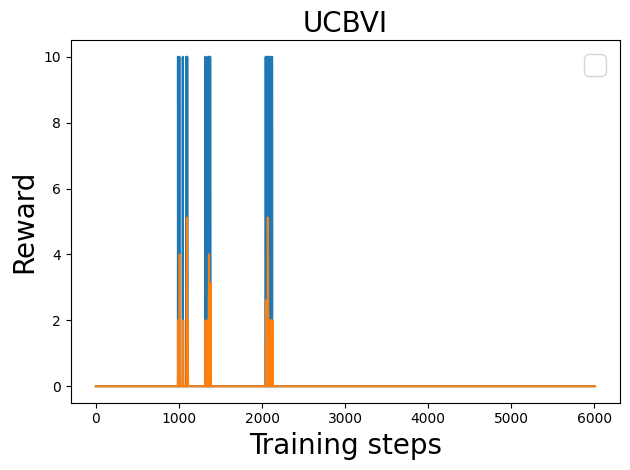

In [4]:
import gym
import numpy as np
import pprint


# Create the environment
observation_space_n = env.H * env.S
action_space_n = env.A
# Parameters
alpha = 0.20  # Confidence threshold for exploration
H = env.H  # Maximum time steps from the environment

# Initialize data structures
H = env.H
S = env.S
A = env.A



s_UCBVI = []
D = {}
Q = np.full((H, S, A), H)  # Q-values
Hits = np.zeros((H, S, A), dtype = 'int')
reward_total = 0
log_U = logger(['Epoch'])



# Iterations
for k in range(n_epochs):
  V = np.zeros(S)  # State values
  reward_epoch = 0

  # Value iteration
  for h in reversed(range(H)):
    for s in range(S):
      Qs = []
      for a in range(A):
         if (h,s,a) in D:
            N_sa = len(D[(h,s,a)]) # visit count for (s, a)
            Hits[h,s,a] = N_sa
            N_sas = { sn: D[(h,s,a)].count(sn) for sn in range(S) }
            P = { sn: N_sas[sn]/N_sa for sn in range(S) }
            reward = env.reward((h,s))/env.R # Reward normalized to [0..1]
            bonus = np.sqrt(1/N_sa)
            Qsa = min(H, reward + sum(P[sn]*V[sn] for sn in range(S)) + alpha * H * bonus)
            Q[h,s,a] = Qsa
            Qs.append(Qsa)

      if len(Qs)>0: V[s] = max(Qs) # max_a Q(a) if (h,s,a) in D


  # Policy execution
  seq = []
  state = env.reset()
  s = state[1]
  Vep = 0 # V epoch
  for h in range(H):
    a = np.argmax(Q[h,s,:]) # get action
    Vep += Q[h,s,a]
    next_state, reward, done, _ = env.step(a) # simulate environment
    next_s = next_state[1]
    seq.append((s,a))
    D.setdefault((h, s, a), []).append(next_s)  # Store experience
    s = next_s  # Update current state
    if done:  # Episode ends if goal reached or failure
        reward_total += reward
        reward_epoch += reward

        break
  log_U.add_item('Epoch',reward_epoch) # Save V(epoch) in logger

  if k % 100 == 0: print(f'epoch:{k}, cum reward:{reward_total}')

# Display
disp(log_U, 'UCBVI','Epoch')
s_UCBVI = np.array(log_U.get_log('Epoch'))



---

# Problems 3 & 4: Implementation DQN & DQN-RND:

It has been created a common class: ** DQN_RND** that implements both the DQN and the DQN-RND algorithms. This class is used in problems 3 & 4. The selection of the Network architecture is done with the **isRND** argument

In [5]:
import torch
import numpy as np
import copy
import torch.nn.functional as F
from collections import deque

import random
np.set_printoptions(precision=3)




# NNs =============

class NN(torch.nn.Module):
    def __init__(self,in_dim,out_dim,n_hid):
        super(NN, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_hid = n_hid

        self.fc1 = torch.nn.Linear(in_dim,n_hid,'linear')
        self.fc2 = torch.nn.Linear(n_hid,n_hid,'linear')
        self.fc3 = torch.nn.Linear(n_hid,out_dim,'linear')
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        #y = self.softmax(y)
        return y


class RND:
    def __init__(self,in_dim,out_dim,n_hid):
        self.target = NN(in_dim,out_dim,n_hid)
        self.model = NN(in_dim,out_dim,n_hid)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.0001)

    def get_reward(self,x):
        y_true = self.target(x).detach()
        y_pred = self.model(x)
        reward = torch.pow(y_pred - y_true,2).sum()
        return reward

    def update(self,Ri):
        Ri.sum().backward()
        self.optimizer.step()


class QNet(torch.nn.Module):
    def __init__(self,in_dim,out_dim,n_hid):
        super(QNet, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.n_hid = n_hid

        self.fc1 = torch.nn.Linear(in_dim,n_hid,'relu')
        self.fc2 = torch.nn.Linear(n_hid,out_dim,'linear')

    def forward(self,x):
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y


# DQN / DQN_RND =============

class DQN_RND:
    def __init__(self, env, gamma,  buffer_size, state_size = 2, action_size = 10, hidden_size = 128, seq_length = 21, isRND = True):

        self.env = env
        self.hidden_size = hidden_size
        self.model = QNet(state_size, action_size, hidden_size)     # NN model
        self.target_model = copy.deepcopy(self.model) # NN target
        self.isRND = isRND
        if isRND: self.rnd = RND(state_size, hidden_size, 16)           # NN rdn
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001) # model
        self.batch_size = 64
        self.epsilon = 0.1
        self.buffer_size = buffer_size
        self.step_counter = 0
        self.epsi_high = 0.7
        self.epsi_low = 0.05
        self.seq_length = seq_length
        self.steps = 0
        self.count = 0
        self.decay = 200
        self.steps_per_epoch = 1
        self.eps = self.epsi_high
        self.update_target_step = 1500
        self.log = logger(['Epoch','reward','exit'])
        self.replay_buffer = deque(maxlen=buffer_size) # memory buffer

    def run_episode(self):
        obs = self.env.reset()
        sum_r = 0
        sum_tot_r = 0
        mean_loss = mean_val()
        Vep = 0
        for t in range(self.seq_length+1): #sequence
            self.steps += 1
            self.eps = self.epsi_low + (self.epsi_high-self.epsi_low) * (np.exp(-1.0 * self.steps/self.decay))
            state = torch.Tensor(obs).unsqueeze(0)
            Q = self.model(state)
            num = np.random.rand()

            # €-greedy select action
            if (num < self.eps):
                action = torch.randint(0,Q.shape[1],(1,)).type(torch.LongTensor)
            else:
                action = torch.argmax(Q,dim=1)
            Vep += torch.max(Q,dim=1).values.item()
            new_state, reward, done, info = self.env.step((action.item()))

            sum_r = sum_r + reward
            reward_i = self.rnd.get_reward(state).detach().clamp(-1.0,1.0).item() if self.isRND else 0
            combined_reward = reward + reward_i
            sum_tot_r += reward

            # ----------
            self.replay_buffer.append([obs,action,combined_reward,new_state,done]) # add to memory buffer

            for _ in range(self.steps_per_epoch):
                loss = self.update_model() # repeat?

            mean_loss.append(loss)

            obs = new_state

            self.step_counter = self.step_counter + 1

            # update target network (slowly)
            if (self.step_counter > self.update_target_step):
                self.target_model.load_state_dict(self.model.state_dict())
                self.step_counter = 0
                print('updated target model')
            if done:
              break
        if reward > 0: print('    >>> ', self.step_counter, 'reward:', reward)

        # logs
        # self.log.add_item('exit',info)
        # self.log.add_item('real_return',sum_r)
        self.log.add_item('reward',sum_tot_r)
        # self.log.add_item('avg_loss',mean_loss.get())
        self.log.add_item('Epoch',sum_tot_r)
        self.log.add_item('exit',info)


    def update_model(self):
        self.optimizer.zero_grad()
        num = len(self.replay_buffer)
        K = np.min([num,self.batch_size])
        samples = random.sample(self.replay_buffer, K)

	    # extract from memory buffer
        S0, A0, R1, S1, D1 = zip(*samples)
        S0 = torch.tensor( S0, dtype=torch.float) # current state
        A0 = torch.tensor( A0, dtype=torch.long).view(K, -1)

        R1 = torch.tensor( R1, dtype=torch.float).view(K, -1) # reward
        S1 = torch.tensor( S1, dtype=torch.float) # next state
        D1 = torch.tensor( D1, dtype=torch.float) # done

		# Update RDN network
        if self.isRND:
            Ri = self.rnd.get_reward(S0)
            self.rnd.update(Ri)

		# Q values
        target_q = R1.squeeze() + self.gamma*self.target_model(S1).max(dim=1)[0].detach()*(1 - D1)
        policy_q = self.model(S0).gather(1,A0)
        L = F.smooth_l1_loss(policy_q.squeeze(),target_q.squeeze())
        L.backward()
        self.optimizer.step()
        return L.detach().item()

    def run_epoch(self):
        self.run_episode()
        return self.log

## Problem 3
Implement the DQN algorithm (with experience replay and target network) with ϵ-greedy exploration, i.e. the agent use the action at =
arg maxa Qt(st) with probability 1−ϵ and at = Unif(A) with probability ϵ. You
are free to tune ϵ as well as other hyper-parameters in DQN as you wish. Use
a two-layer MLP for the Q-network.

/var/folders/xs/jd50wml538gbmgccpcd6l9400000gn/T/ipykernel_3542/3569284161.py:161: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  S0 = torch.tensor( S0, dtype=torch.float) # current state


0 > epoch: 0, Vep: 0, reward: 0
0 > epoch: 50, Vep: 0, reward: 0
updated target model
0 > epoch: 100, Vep: 0, reward: 0
0 > epoch: 150, Vep: 0, reward: 0
updated target model
0 > epoch: 200, Vep: 0, reward: 0
updated target model
0 > epoch: 250, Vep: 0, reward: 0
0 > epoch: 300, Vep: 0, reward: 0
updated target model
0 > epoch: 350, Vep: 0, reward: 0
updated target model
0 > epoch: 400, Vep: 0, reward: 0
0 > epoch: 450, Vep: 0, reward: 0
updated target model
0 > epoch: 500, Vep: 0, reward: 0
0 > epoch: 550, Vep: 0, reward: 0
updated target model
0 > epoch: 600, Vep: 0, reward: 0
updated target model
0 > epoch: 650, Vep: 0, reward: 0
0 > epoch: 700, Vep: 0, reward: 0
updated target model
0 > epoch: 750, Vep: 0, reward: 0
updated target model
0 > epoch: 800, Vep: 0, reward: 0
0 > epoch: 850, Vep: 0, reward: 0
updated target model
0 > epoch: 900, Vep: 0, reward: 0
updated target model
0 > epoch: 950, Vep: 0, reward: 0
0 > epoch: 1000, Vep: 0, reward: 0
updated target model
0 > epoch: 1050

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0 0]
state: [0 0] action: 8 reward: 0
state: [1 2] action: 8 reward: 0
state: [2 2] action: 8 reward: 0
state: [3 2] action: 8 reward: 0
state: [4 2] action: 5 reward: 0
state: [5 2] action: 5 reward: 0
state: [6 2] action: 5 reward: 0
state: [7 2] action: 5 reward: 0
state: [8 2] action: 5 reward: 0
state: [9 2] action: 5 reward: 0
state: [10  2] action: 5 reward: 0
state: [11  2] action: 5 reward: 0
state: [12  2] action: 5 reward: 0
state: [13  2] action: 5 reward: 0
state: [14  2] action: 5 reward: 0
state: [15  2] action: 5 reward: 0
state: [16  2] action: 5 reward: 0
state: [17  2] action: 5 reward: 0
state: [18  2] action: 5 reward: 0


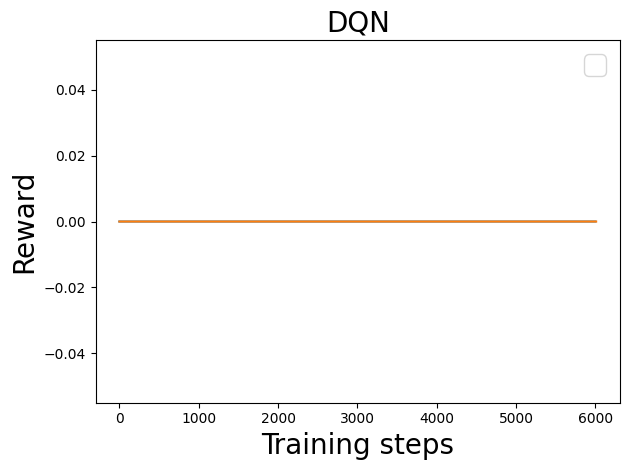

In [6]:
gamma = 0.9
n_series = 1
s_DQN = []
for s in range(n_series):
  alg = DQN_RND(env,gamma,4000, isRND = False)

  for i in range(n_epochs):
    log_DQN = alg.run_epoch()
    if i%50 == 0: print(s,'> epoch: {}, Vep: {}, reward: {}'.format(i, log_DQN.get_current('Epoch'), log_DQN.get_current('reward')) )
  s_DQN.append(log_DQN.get_log('Epoch'))
s_DQN = np.array(s_DQN)

# Display
disp1(np.mean(s_DQN, axis=0), 'DQN','Epoch')


# Test sequence
obs = env.reset()
print(obs)
for t in range(1000):
    x = torch.Tensor(obs).unsqueeze(0)
    Q = alg.model(x)
    action = Q.argmax().detach().item()
    new_obs, reward, done, info = env.step(action)
    print('state:', obs,  'action:', action, 'reward:',reward)

    obs = new_obs
    if done:
        break

# Problem 4 (3 points)

Implement DQN with RND using a randomly neural network as the target network $f:S\rightarrow \mathbb{R}^d$, and use the reward bonus in the form of $\alpha||\hat{f}(s)-f(s)||_2^2$.

Run DQN+RND in the combination lock MDP (with turned hyperparameters, including $\alpha$, the replay buffer size, learning rates, etc) and plot its learning curve: Cumulative reward v.s. training episode same as in HW2.

An example implementation of DQN+RND can be found [here](https://github.com/orrivlin/MountainCar_DQN_RND).

0 > epoch: 0, Vep: 0, reward: 0
0 > epoch: 50, Vep: 0, reward: 0
0 > epoch: 100, Vep: 0, reward: 0
0 > epoch: 150, Vep: 0, reward: 0
0 > epoch: 200, Vep: 0, reward: 0
updated target model
0 > epoch: 250, Vep: 0, reward: 0
0 > epoch: 300, Vep: 0, reward: 0
0 > epoch: 350, Vep: 0, reward: 0
0 > epoch: 400, Vep: 0, reward: 0
updated target model
0 > epoch: 450, Vep: 0, reward: 0
0 > epoch: 500, Vep: 0, reward: 0
0 > epoch: 550, Vep: 0, reward: 0
0 > epoch: 600, Vep: 0, reward: 0
updated target model
0 > epoch: 650, Vep: 0, reward: 0
0 > epoch: 700, Vep: 0, reward: 0
0 > epoch: 750, Vep: 0, reward: 0
0 > epoch: 800, Vep: 0, reward: 0
0 > epoch: 850, Vep: 0, reward: 0
updated target model
0 > epoch: 900, Vep: 0, reward: 0
0 > epoch: 950, Vep: 0, reward: 0
0 > epoch: 1000, Vep: 0, reward: 0
0 > epoch: 1050, Vep: 0, reward: 0
updated target model
0 > epoch: 1100, Vep: 0, reward: 0
0 > epoch: 1150, Vep: 0, reward: 0
0 > epoch: 1200, Vep: 0, reward: 0
0 > epoch: 1250, Vep: 0, reward: 0
updated 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    >>>  1403 reward: 10
    >>>  1410 reward: 10
    >>>  1445 reward: 10
    >>>  1452 reward: 10
    >>>  1459 reward: 10
    >>>  1466 reward: 10
    >>>  1473 reward: 10
[0 1]
state: [0 1] action: 5 reward: 0
state: [1 0] action: 0 reward: 0
state: [2 1] action: 3 reward: 0
state: [3 0] action: 3 reward: 0
state: [4 0] action: 7 reward: 0
state: [5 0] action: 9 reward: 0
state: [6 1] action: 3 reward: 10


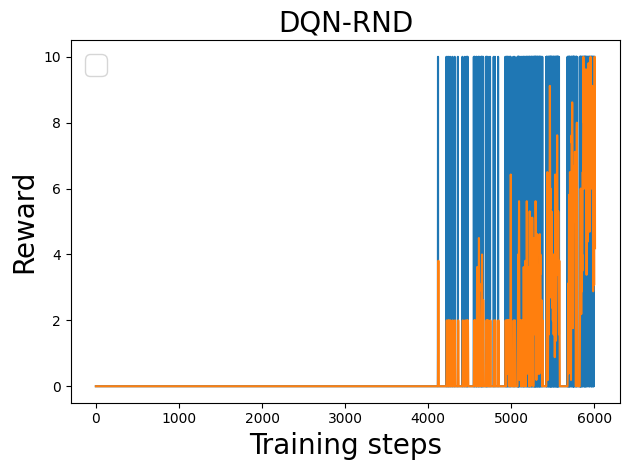

In [7]:
gamma = 0.9
n_series = 1
env = CombLockMDP(H = 8, A = 10)
s_RND = []
for s in range(n_series):
  alg = DQN_RND(env,gamma,4000, isRND = True)

  for i in range(n_epochs):
      log_DQN_RND = alg.run_epoch()
      if i%50 == 0: print(s, '> epoch: {}, Vep: {}, reward: {}'.format(i, log_DQN_RND.get_current('Epoch'), log_DQN_RND.get_current('reward')) )
  s_RND.append(log_DQN_RND.get_log('Epoch'))
s_RND = np.array(s_RND)

# Display
disp1(np.mean(s_RND, axis=0), 'DQN-RND','Epoch')






# Test sequence
obs = env.reset()
print(obs)
for t in range(1000):
    x = torch.Tensor(obs).unsqueeze(0)
    Q = alg.model(x)
    action = Q.argmax().detach().item()
    new_obs, reward, done, info = env.step(action)
    print('state:', obs,  'action:', action, 'reward:',reward)

    obs = new_obs
    if done:
        break


# Problem 5
Plot the performance curve of UCBVI, DQN with $\epsilon$-greedy, and DQN+RND in the same figure.

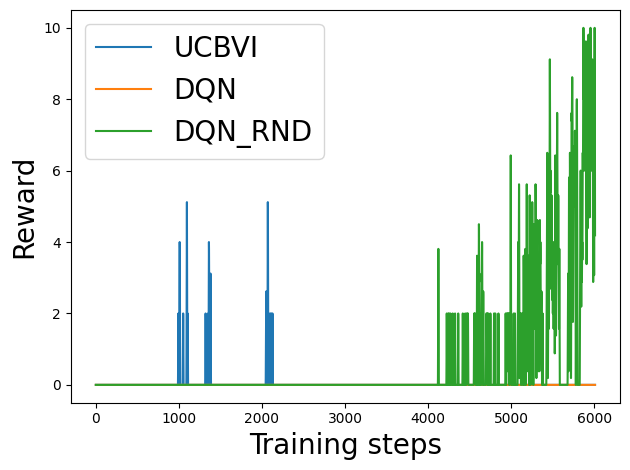

In [8]:
figsize=(20, 16)
fontsize = 20
plt.Figure(figsize)
Y = smooth(np.asarray(log_U.get_log('Epoch')))
Y2 = smooth(np.mean(s_DQN, axis=0))
Y3 = smooth(np.mean(s_RND, axis=0))
x = np.linspace(0, len(Y), len(Y))
fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, Y,  label="UCBVI") # UCBVI
ax1.plot(x, Y2, label="DQN") #DQN
ax1.plot(x, Y3, label="DQN_RND") #DQN_RND
plt.legend(fontsize=fontsize)

plt.xlabel("Training steps", fontsize=fontsize)
plt.ylabel("Reward", fontsize=fontsize)
plt.tight_layout()
plt.savefig("hw3.png", dpi=300)